<font size="6"> __Mesure de Similarité par distance de Wasserstein dans le cas des Séries Temporelles__ </font>
___

La méthode utilisée est celle de la distance de Wasserstein-Fourier telle que présentée dans l'article:
>Elsa Cazelles, Arnaud Robert, Felipe Tobar. The Wasserstein-Fourier Distance for Stationary Time Series. IEEE Transactions on Signal Processing, Institute of Electrical and Electronics Engineers, 2021, 69, pp.709-721. 10.1109/TSP.2020.3046227. hal-03115531

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import numpy.linalg as npl
import scipy.io as spio
from scipy import interpolate
import mat73
import os
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
import animatplot as amp

import pandas as pd
import csv

import toolbox.tools_signal as ts
import toolbox.geodesic as tg


import ot
import ot.plot

# Fonctions

In [30]:
class Station:
    """Definition d'une station : 
    
    #####Attributes#####
    name    : 'CHLAOC5' or 'SPM_BingHan'
    station : station number
    res     : 'big' or 'small'
    mod     : 'X' by default, 'T','S','I'
    S_raw   : the original 3D matrix of time series
    ref     : the position of the reference station
    S_inter : (initialized by interpolateAllSignal) matrix of interpolated time series (gets rid of NaN)
    
    #####Methods##### 
    Station.getSignal(x,y,interpolation=True)
    Station.interpolateAllSignal()
    Station.dataToGif()
    Station.dataToPSD(freq)
    Station.WassersteinNPSD(freq,mu=0)
    """

    def __init__(self,name,station,res,mod='X'):
        self.name = name
        self.station = station
        self.res = res
        self.mod = mod
        data_path = os.getcwd()+'\DATA'
        filename = data_path+'\\'+self.name+'_'+self.res+'\Somlit_'+str(self.station)+'_'+self.name+'_'+self.mod+'.mat'
        if name=='CHLAOC5':
            mat = spio.loadmat(filename)
        elif name=='SPM_BingHan':
            mat = mat73.loadmat(filename)
        self.S_raw = mat[[*mat][-1]]    
        refs_filename = data_path+'\\'+name+'_'+res+'\\ref_station.csv'
        refs = np.loadtxt(refs_filename,delimiter=',',dtype='int')
        self.ref = refs[np.where(refs[:,0]==station),1:][0,0]
    
    def getSignal(self,x,y,interpolation='True'):
        """
        Station.getSignal(S,x,y,interpolation='True')

            Gets the time series at position (x,y)

            Parameters : x,y           : the position where we want to get the time serie
                         interpolation : default = True. When True, it will ignore largely corrupted signals 
                                         (number of NaN > half of acquisition times) and interpolate scarcely NaN signals
            Returns    : s : The extracted time serie
                         t : The indexes of the raw s where the values were non_NaN
        """
        n,m,T=np.shape(self.S_raw)
        s = np.copy(self.S_raw[x,y,:])
        t = (~np.isnan(s)).nonzero()
        t = np.reshape(t,np.shape(s[t]))
        # On effectue un traitement qui permet de "combler les trous" pour les signaux ayant un certain nombre de NaN 
        # et supprimer ceux en ayant trop
        if np.count_nonzero(np.isnan(s))!=0 and interpolation:
            if np.count_nonzero(np.isnan(s))>=T/2:
                s[:] = np.nan
                t = (~np.isnan(s)).nonzero()
                t = np.reshape(t,np.shape(s[t]))
            else:
                fs = interpolate.interp1d(t,s[t])         # On interpole les valeurs qu'on sait être non NaN
                s = fs(np.arange(t[0],t[-1]+1))                 # puis on reconstruit le signal jusqu'au maximum (dernier t non Nan)
        return s,t     
    
    def interpolateAllSignal(self):
        """
        Station.interpolateAllSignal()

            Makes an interpolation for every time series in the S_raw matrix and initializes Station.S_inter

            Returns  :  Station.S_inter : The interpolated (cleaned) matrix of time series
        """
        n,m,T=np.shape(self.S_raw)
        Stemp = np.empty(np.shape(self.S_raw))
        Stemp[:] = np.nan 
        Tmaxs = []
        Tmins = []
        for i in range(n):
            for j in range(m):
                s,t = self.getSignal(i,j)
                if len(t)!=0:
                    Stemp[i,j,t[0]:t[-1]+1] = s
                    Tmaxs += [t[-1]+1]
                    Tmins += [t[0]]
        Tmax = min(Tmaxs)
        Tmin = max(Tmins)
        self.S_inter = Stemp[:,:,Tmin:Tmax]
    
    def dataToGIF(self,interpolate=False):
        """
        Station.dataToGIF()

            Creates a .gif file representing the progress of the raw time series over the entire map
            
            Parameter:  interpolate : default = False. If false, generates GIF for raw data, else for interpolated data
            Returns  :  gifname : String, the name of the created gif file
        """
        if interpolate:
            S=self.S_inter
        else:
            S=self.S_raw
            
        gifname = self.name+'_'+self.res+'_'+str(self.station)+'_'+self.mod
        
        n,m,c = S.shape
        x = np.arange(m)
        y = np.arange(n)
        t = np.arange(c)
        X,Y,T = np.meshgrid(x,y,t)
        
        plt.figure(figsize=(5,5*n/m))
        plt.title('Station '+self.name)
        
        pcolormesh_block = amp.blocks.Pcolormesh(X[:,:,0], Y[:,:,0], S, t_axis=2)
        plt.colorbar(pcolormesh_block.quad)
        plt.plot(SPM_BH.ref[1],SPM_BH.ref[0], marker="o", markersize=20, markerfacecolor='r')

        timeline = amp.Timeline(t,fps=10)
        anim = amp.Animation([pcolormesh_block],timeline)
        anim.controls()
        anim.save_gif(gifname)
        plt.close()
        Image(url=gifname+'.gif')
        return gifname+'.gif'
    
    def dataToPSD(self,freq):
        """
        Station.dataToPSD(freq)
        
            Given a signal matrix, computes the PSD for each of its pixel/time series

            Parameters:  freq : array of frequencies on which to compute the NPSD
            
            Returns :    PSD : the power spectral density
        """
        n,m,T = np.shape(self.S_inter)
        PSD = np.zeros((n,m,len(freq)))
        times = np.linspace(0,1,T)
        for x in range(n):
            for y in range(m):
                s = self.S_inter[x,y,:]
                if not(np.any(np.isnan(s))):
                    PSD[x,y,:] = ts.Signal2PSD(freq,times,s)
                else:
                    PSD[x,y,:] = np.nan
        return PSD
    
    def dataToWassersteinNPSD(self,freq,mu=0):
        """
        Station.dataToWassersteinNPSD(freq,mu=0)
        
            Computes the Wasserstein-Fourier distance over the given signals as presented in the article "The Wasserstein-Fourier Distance for Stationary Time Series"
            We also add a weight parameter mu which allows to take into consideration the norm differences
            
            Parameters:  freq : array of frequencies on which to compute the NPSD
                         mu   : the weight parameters that multiplies the norm difference
        """
        PSD = self.dataToPSD(freq)
        n,m,F = np.shape(PSD)
        psd_ref = PSD[self.ref[0],self.ref[1],:]
        norm_psd_ref = np.sum(psd_ref)
        npsd_ref = psd_ref/norm_psd_ref

        M = ot.dist(freq.reshape((F,1)),freq.reshape((F,1)))
        M /= M.max()

        WImage = np.zeros((n,m))
        for x in range(n):
            for y in range(m):
                if not(np.any(np.isnan(PSD[x,y]))):
                    psd = PSD[x,y]
                    norm_psd = np.sum(psd)
                    npsd = psd/norm_psd
                    WImage[x,y] = ot.emd2(npsd,npsd_ref,M) + mu*np.abs(norm_psd-norm_psd_ref)
                else :
                    WImage[x,y] = np.nan
        return WImage, M
    
    

# Choix de la station 
revenir ici pour changer les valeurs

In [33]:
# name = 'CHLAOC5' #ou 
name = 'SPM_BingHan'
station=10
mod='X'
res='big'
x,y = [130,30]

SPM_BH = Station(name,station,res,mod)
SPM_BH.interpolateAllSignal()

# Manipulations

## Visualisation des données  

Dans un premier temps, on visualise l'évolution de chaque séries temporelles de la carte avec un GIF

In [23]:
gif1 = SPM_BH.dataToGIF()

D:\applications\Anaconda\lib\site-packages\animatplot\blocks\image_like.py:71: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  self.quad = self.ax.pcolormesh(self.X, self.Y, self.C[Slice], **kwargs)


In [24]:
Image(url=gif1)

On voit bien que certains pixels de la carte prennent des valeurs NaN périodiquement. On fait donc une interpolation pour combler les trous de courte durée dans les données.

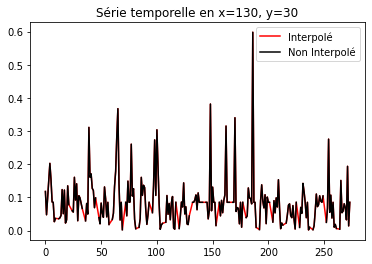

In [22]:
s,_  = SPM_BH.getSignal(x,y,False)
sp,_ = SPM_BH.getSignal(x,y)
plt.figure()
plt.plot(sp,'r',label='Interpolé')
plt.plot(s,'black',label='Non Interpolé')
plt.title('Série temporelle en x=%i, y=%i' %(x,y))
plt.legend()

Comparaison d'une série au point de référence avec une série à un point quelconque

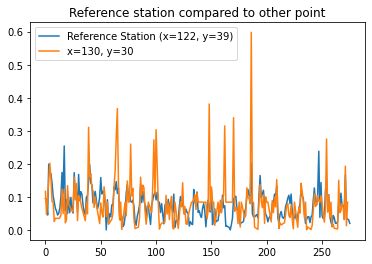

In [28]:
s_ref,_ = SPM_BH.getSignal(SPM_BH.ref[0],SPM_BH.ref[1])
s,_     = SPM_BH.getSignal(x,y)
plt.plot(s_ref,label='Reference Station (x=%i, y=%i)' %(SPM_BH.ref[0],SPM_BH.ref[1]))
plt.plot(s,label='x=%i, y=%i' %(x,y))
plt.title('Reference station compared to other point')
plt.legend()
plt.show()

## Passage en domaine fréquentiel

Le but de la méthode de mesure de distance Wasserstein-Fourier est d'effectuer une transformation en power spectral density (PSD) du signal. On renormalise ensuite cette PSD pour obtenir la NPSD. On considère ensuite que cette NPSD est une distribution 1D discète (un histogramme où les bins sont les niveaux de fréquence et la hauteur est l'énergie associé à cette plage de fréquence dans la NPSD).  
On pourra ensuite calculer la distance de Wasserstein sur ces NPSD.  
  
On peut dans un premier temps comparer les PSD ainsi que les NPSD entre la référence et un point quelconque

In [34]:
n = 501
frequencies = np.linspace(-15,15,n)

PSD = SPM_BH.dataToPSD(frequencies)

Text(0.5, 1.0, 'Normalized PSD comparison')

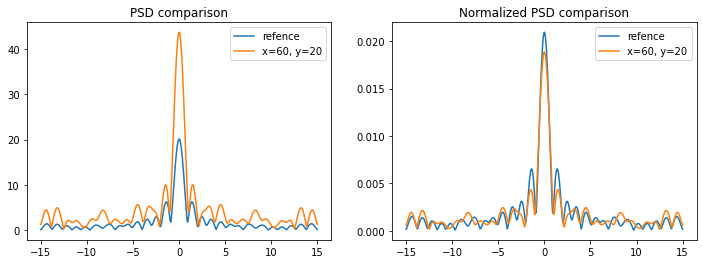

In [40]:
x,y = [60,20]
psd_ref = PSD[SPM_BH.ref[0],SPM_BH.ref[1],:]
psd     = PSD[x,y]

npsd_ref = psd_ref/np.sum(psd_ref)
npsd     = psd/np.sum(psd)

fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(frequencies,psd_ref,label='refence')
axs[0].plot(frequencies,psd,label='x=%i, y=%i' %(x,y))
axs[0].legend()
axs[0].set_title('PSD comparison')

axs[1].plot(frequencies,npsd_ref,label='refence')
axs[1].plot(frequencies,npsd,label='x=%i, y=%i' %(x,y))
axs[1].legend()
axs[1].set_title('Normalized PSD comparison')

# Calcul de la distance de Wasserstein-Fourier

In [41]:
WIm,M = SPM_BH.dataToWassersteinNPSD(frequencies,mu=0)

In [ ]:
WIm2,M2 = SPM_BH.dataToWassersteinNPSD(frequencies,mu=2e-5)

In [ ]:
n,m = np.shape(WIm)
plt.figure(figsize=(12,m/n*12))
plt.imshow(WIm)
plt.plot(pos[1],pos[0], marker="o", markersize=20, markerfacecolor='r')
plt.title('Wasserstein Distance to the reference')
plt.colorbar()
plt.show()

fig,ax = plt.subplots(figsize=(4,4*n/m))
CF = ax.contourf(WIm[::-1,:],levels=5)
CNF = ax.contour(CF, levels=CF.levels, colors='r')
ax.set_title('Wasserstein Distance to the reference by Level')
ax.plot(pos[1],n-pos[0], marker="o", markersize=20, markerfacecolor='r')
cbar = fig.colorbar(CF)
cbar.ax.set_ylabel('Wasserstein Distance')

In [ ]:
n,m = np.shape(WIm2)
plt.figure(figsize=(12,m/n*12))
plt.imshow(WIm2)
plt.plot(pos[1],pos[0], marker="o", markersize=20, markerfacecolor='r')
plt.title('Wasserstein Distance to the reference')
plt.colorbar()
plt.show()

fig,ax = plt.subplots(figsize=(4,4*n/m))
CF = ax.contourf(WIm2[::-1,:],levels=5)
CNF = ax.contour(CF, levels=CF.levels, colors='r')
ax.set_title('Wasserstein Distance to the reference by Level')
ax.plot(pos[1],n-pos[0], marker="o", markersize=20, markerfacecolor='r')
cbar = fig.colorbar(CF)
cbar.ax.set_ylabel('Wasserstein Distance')